# Plot a field of streams 

This notebook takes healpix matched filter maps of DES, DECaLS and Gaia and uses them to create a field of streams map

In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from skimage.morphology import diameter_closing
import pandas as pd

In [2]:
def apwnorm(x, min=None, max=None):
    if min is None:
        min = np.nanmin(x[~np.isinf(x)])
    if max is None:
        max = np.nanmax(x[~np.isinf(x)])
    return np.clip((x - min) / (max - min), 0, 1)

def renorm_rgb(rgb, pmin=1, pmax=99):
    for i in range(3):
        X = rgb[i]

        amin = np.nanpercentile(np.ma.filled(X, np.nan), pmin)
        amax = np.nanpercentile(np.ma.filled(X, np.nan), pmax)

        rgb[i] = apwnorm(X, min=amin, max=amax)
        rgb[i][X == 0] = 0.

    return rgb   
    
def get_img(proj, rgb, pmin=0.2, pmax=93):
    rgb = np.ma.copy(rgb)
    rgb = renorm_rgb(rgb, pmin=pmin, pmax=pmax)
    
    for i in range(3):
        rgb[i][mask_arr==1]=gaia_m[mask_arr==1]
    img = np.stack([proj.projmap(rgb[i].filled(np.nan), vec2pix) 
                    for i in range(3)], axis=-1)

    return img

def stack_img(img_list):
    img = img_list[0]
    for im in img_list[1:]:
        idx = np.isfinite(im) & ~np.isnan(im) & (im > 0)
        img[idx] = im[idx]
    return img

def func_vec2pix(nside):
    return lambda x, y, z: hp.vec2pix(nside, x, y, z)

def get_lsst_line(filepath="../data/survey_footprints/lsst_boundary.csv"):
    lsst_coords = pd.read_csv(filepath)
    lsst_coords = lsst_coords.sort_values("wrap_order")
    lsst_ra = lsst_coords["ra"].values
    lsst_ra[lsst_ra > 180] -=360
    lsst_dec = lsst_coords["dec"].values
    return lsst_ra, lsst_dec

def draw_polygon(ax, proj, lon, lat, edgecolor='red', linestyle='solid', facecolor=None, **kwargs):
    """Plot a polygon from a list of lon, lat coordinates.

    This routine is a convenience wrapper around plot() and fill(), both
    of which work in geodesic coordinates.

    Parameters
    ----------
    lon : `np.ndarray`
        Array of longitude points in polygon.
    lat : `np.ndarray`
        Array of latitude points in polygon.
    edgecolor : `str`, optional
        Color of polygon boundary.  Set to None for no boundary.
    linestyle : `str`, optional
        Line style for boundary.
    facecolor : `str`, optional
        Color of polygon face.  Set to None for no fill color.
    **kwargs : `dict`, optional
        Additional keywords passed to plot.
    """
    plt.sca(ax)
    lon, lat = np.append(lon, lon[0]), np.append(lat, lat[0])
    x, y = proj.ang2xy(lon, lat, lonlat=True)
    if linestyle is not None and edgecolor is not None:
        plt.plot(x, y, color=edgecolor, linestyle=linestyle, **kwargs)
    if facecolor is not None:
        plt.fill(x, y, color=facecolor, **kwargs)

In [3]:
nside=512
vec2pix = func_vec2pix(nside)

# Read in data 
This data includes:
- decals matched filter maps
- dec matched filter maps 
- Mask to clean up decam data
- gaia density map (a little processing is done on this map)

In [4]:
rgb_decals = np.load("../data/hpx_maps/decals_dr10_corrected_rgb_nside_512_smooth.npy")
rgb_des= np.load("../data/hpx_maps/des_y6_gold_rgb_stack_nside_512.npy")


mask_arr = fitsio.read("../data/hpx_maps/decam_mask_nside_512.fits")

gaia = fitsio.read("../data/hpx_maps/gaia_dr3_density_nside_512_nest.fits")
gaia= hp.reorder(gaia, n2r=True)
gaia_m = np.ma.masked_invalid(gaia).astype(float)
gaia_m /= np.percentile(gaia_m, 99)
gaia_m = np.clip(gaia_m, 0,1)
rgb_gaia = np.vstack([np.ma.copy(gaia_m) for i in range(3)])
for i in range(3):
    rgb_gaia[i][mask_arr==0]=0

/home/fergie/software/miniconda3/envs/fos2024/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


# project maps and combine
Here we use hp.projector to create a projection and use this to project the healpixel maps into image coordinates and renomalize the pixel values. Subsequently we combine all the data into a single image.

In [5]:
proj = hp.projector.MollweideProj() 
img_des = get_img(proj, rgb_des)
rgb_decals = renorm_rgb(np.ma.copy(rgb_decals), pmin=0.2, pmax=93)
for i in range(3):
    rgb_decals[i][mask_arr==1]=gaia_m[mask_arr==1]

img_decals = np.stack([proj.projmap(rgb_decals[i].filled(np.nan), vec2pix) 
                for i in range(3)], axis=-1)
img = stack_img([img_decals, img_des])

# run morphological closing on the image
this cleans up some of the small gaps in the image but is slow to run

In [6]:
closed_image = img
# un-comment to run morphological closing (this can be a little slow) 
closed_image = diameter_closing(img,connectivity=2, diameter_threshold=10)

# plot data!

In [7]:
# load survey footprints
lsst_ra,lsst_dec = get_lsst_line()
des_coords = np.genfromtxt("../data/survey_footprints/des-round19-poly.txt", names=['ra', 'dec'])
des_ra = np.append(des_coords["ra"], des_coords["ra"][0])
des_dec = np.append(des_coords["dec"], des_coords["dec"][0])



/home/fergie/software/miniconda3/envs/fos2024/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


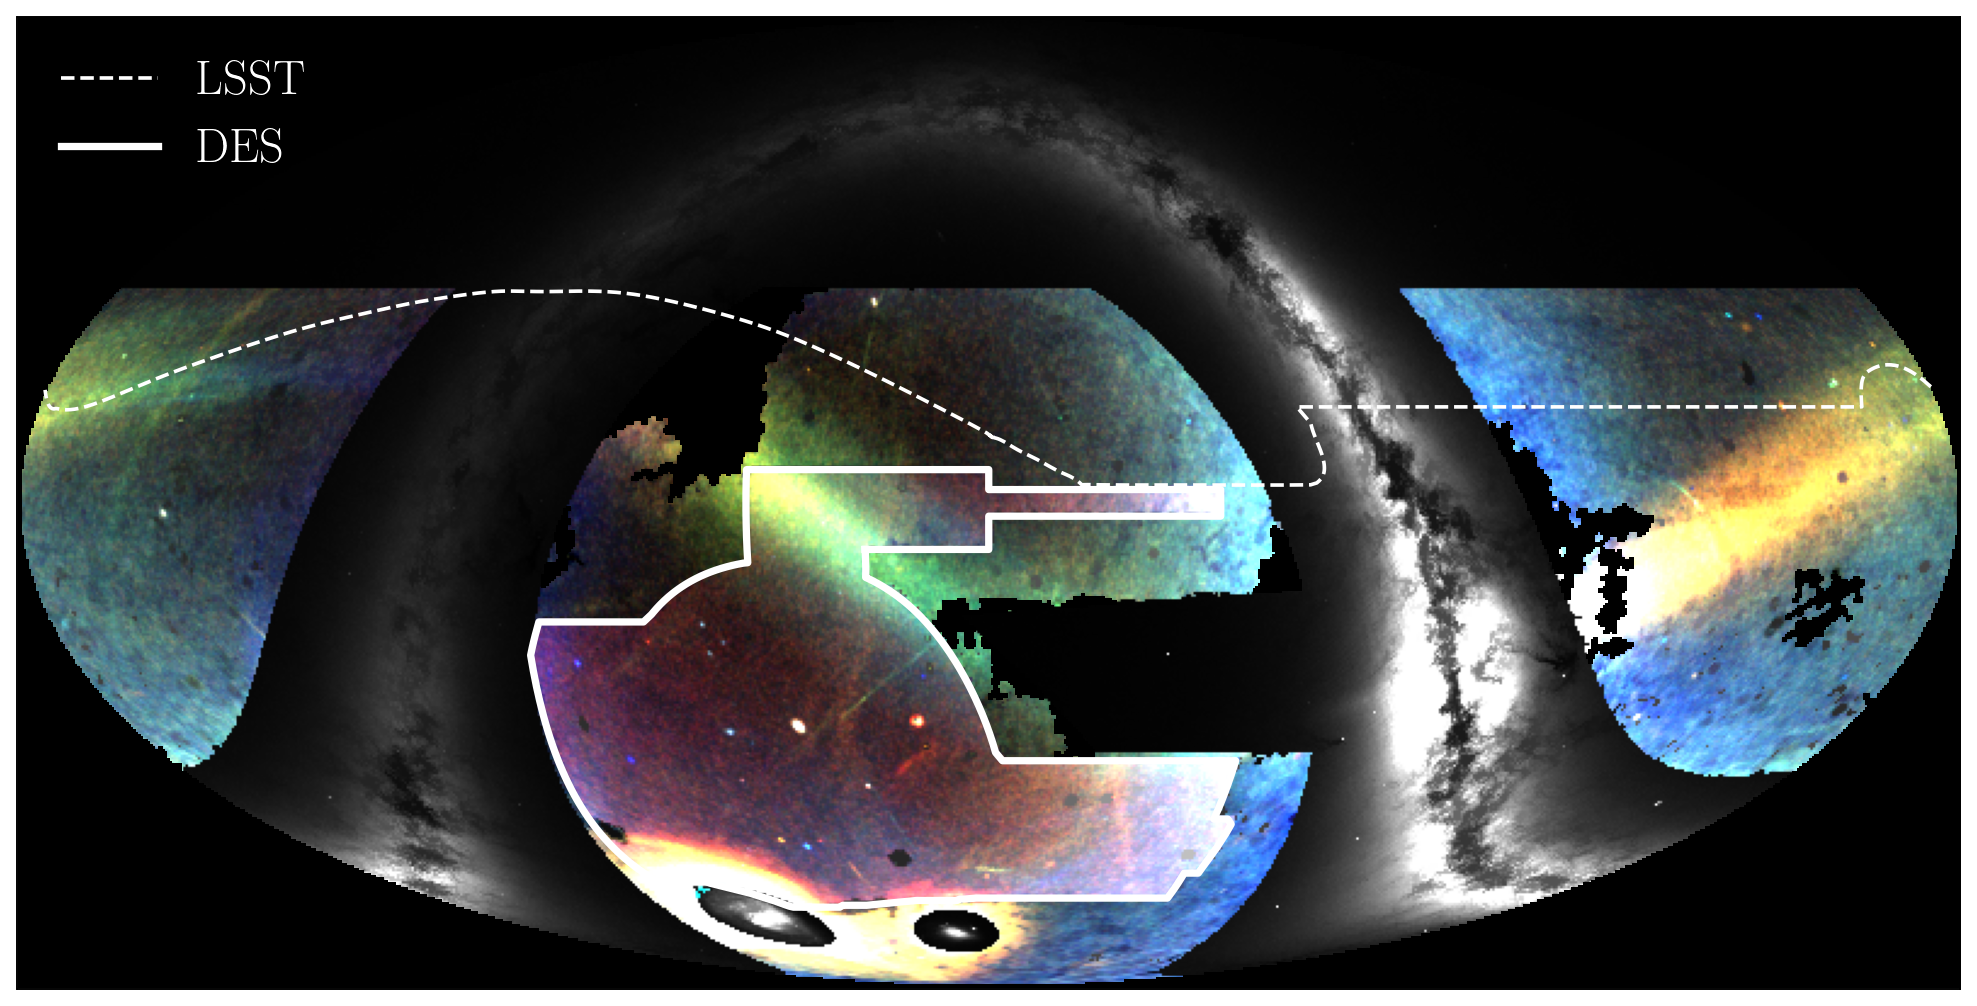

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=175)
ax.imshow(closed_image, origin='lower', extent=proj.get_extent())
x_lsst, y_lsst = proj.ang2xy(lsst_ra, lsst_dec, lonlat=True)
ax.plot(x_lsst,y_lsst, c="white", ls="dashed", label="LSST")
x_des, y_des = proj.ang2xy(des_ra, des_dec, lonlat=True)
ax.plot(x_des,y_des, c="white", ls="solid", label="DES", lw=3)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.legend(loc="upper left", labelcolor="white", facecolor="None", edgecolor="None", fontsize=20)
fig.tight_layout()